## Comparison of Method for Hyperparameter Optimization

In this notebook we compare the results produced running the kdb+/q implementations of Grid, Random, Sobol-Random and Bayesian search. The aim is to find which method performs the best, most consistently. 

Each method has been used to determine hyperparameters for both classification and regression problems, run on datasets of varying sizes.

### Utility functions

The below functions are used to read results from text files into kdb tables and convert them to the required types.

In [1]:
// read results dictionary from txt files
get_data:{fnc:{key(!).("S=,")0:x};$[1<count first x;fnc each;fnc]x}

// get names of model used and dataset
get_mdl_dset:{2#"_"vs ssr[y;x;x,"_"]}

// convert results to correct datatypes in table
load_hpopt_res:{[ptyp;fp;fn]
 // generate model/dataset names from filename
 prms:`$get_mdl_dset[$[ptyp~`class;"Classifier";"Regressor"]]fn;
 // read in results
 d:get_data each@[d;;";"vs]c:where";"in/:d:(!).("S*";"|")0:hsym`$fp,fn;
 // convert columns to correct type
 d:{@[x;y;$[z;]string@]}/[d;`fold_score`random_state`time`score;"FITF"];
 // create individual rows for each fold score (5 contained in 1 row initially)
 d:flip raze each@[d;cols[d]except`fold_score;{count[first x`fold_score]#y}[d]each];
 // select relevant columns
 select mdl:prms 0,dataset:prms 1,method,fold_score,score,time from d}

### Read in results

We start by reading in all text files and separating into tables based on classification/regression problem type.

In [2]:
// split file names into class/reg
files@:where(files:system"ls")like"*.txt"
show files:`class`reg!files(where;where not::)@\:files like"*Classifier*"

// read in results to separate tables
class:raze load_hpopt_res[`class;"./"]each files`class
5#reg:raze load_hpopt_res[`reg;"./"]each files`reg

class| ("AdaBoostClassifierbreastcancer_2020.07.06_18.59.25.990.txt";"AdaBoos..
reg  | ("AdaBoostRegressorcar_2020.07.10_12.59.13.267.txt";"AdaBoostRegressor..


mdl               dataset method fold_score score     time        
------------------------------------------------------------------
AdaBoostRegressor car     grid   0.8503966  0.7316178 00:02:21.214
AdaBoostRegressor car     grid   -15.00031  0.7316178 00:02:21.214
AdaBoostRegressor car     grid   0.7911208  0.7316178 00:02:21.214
AdaBoostRegressor car     grid   0.4229715  0.7316178 00:02:21.214
AdaBoostRegressor car     grid   0.6053808  0.7316178 00:02:21.214


### Separate by model
In order to plot results, we now need to separate each of the results tables by model.

In [3]:
class_mdlres   :{[x;y]select from x where mdl=y}[class]each m:distinct class`mdl
show reg_mdlres:{[x;y]select from x where mdl=y}[reg  ]each m:distinct reg`mdl

+`mdl`dataset`method`fold_score`score`time!(`AdaBoostRegressor`AdaBoostRegres..
+`mdl`dataset`method`fold_score`score`time!(`GradientBoostingRegressor`Gradie..
+`mdl`dataset`method`fold_score`score`time!(`KNeighborsRegressor`KNeighborsRe..
+`mdl`dataset`method`fold_score`score`time!(`RandomForestRegressor`RandomFore..


### Utility functions for plotting

The below functions are used to produce the final plots below.

`prep_for_plot` is required due to the way the plotting function works. It means that we need to know both the numerical/symbol values for the methods used, which requires some preprocessing.

`plot_res` allows us to subplot both result and stats plots.

In [4]:
// python imports
plt:.p.import`matplotlib.pyplot

// prep data for plotting - returning xticks/labels, scores and dataset index
prep_for_plot:{[c2plt;t]
  // distinct methods for xticks
  mtd:(xtick:distinct t`method)!til 4;
  t:update nm:mtd method from t;
  // group data for plotting (model;dataset;method 0-3;scores)
  (first t`mdl;xtick;{[c;t;d]d,value?[t;enlist(=;`dataset;enlist d);();k!k:`nm,c]}[c2plt;t]each dd:distinct t`dataset)}

// plot each model's results as a subplot
plot_res:{[c;typ;r]
  fig:plt[`:figure][`figsize pykw 12 12];
  ax1:fig[`:add_subplot][221];
  ax2:fig[`:add_subplot][222;`sharex pykw ax1;`sharey pykw ax1];
  ax3:fig[`:add_subplot][223;`sharex pykw ax1;`sharey pykw ax1];
  ax4:fig[`:add_subplot][224;`sharex pykw ax1;`sharey pykw ax1];
  ttl:$[b:typ=`stats;"Average ",c;c," comparison"];
  {[typ;ttl;c;a;r]
    subplot_res[typ;string[r 0]," - ",ttl;c;a;r 1]each r 2;
    }[b;ttl;c]'[(ax1;ax2;ax3;ax4);r];
  plt[`:show][];}

// plot statistics or results
subplot_res:{[typ;ttl;c;a;tick;t]
 $[typ;
  a[`:bar][til 4;t[;0];`yerr pykw t[;1];`align pykw`center;`alpha pykw .5;`ecolor pykw`black;`capsize pykw 10];
  a[`:scatter][t 1;t 2;`label pykw t 0]];
 a[`:set_xticks]til 4; 
 a[`:set_xticklabels]tick;
 a[`:set_title]ttl;
 a[`:set_xlabel]`Method;
 a[`:set_ylabel]c;
 $[typ;a[`:yaxis.grid]1b;a[`:legend][]];}

## Graphic results

### Fold score results

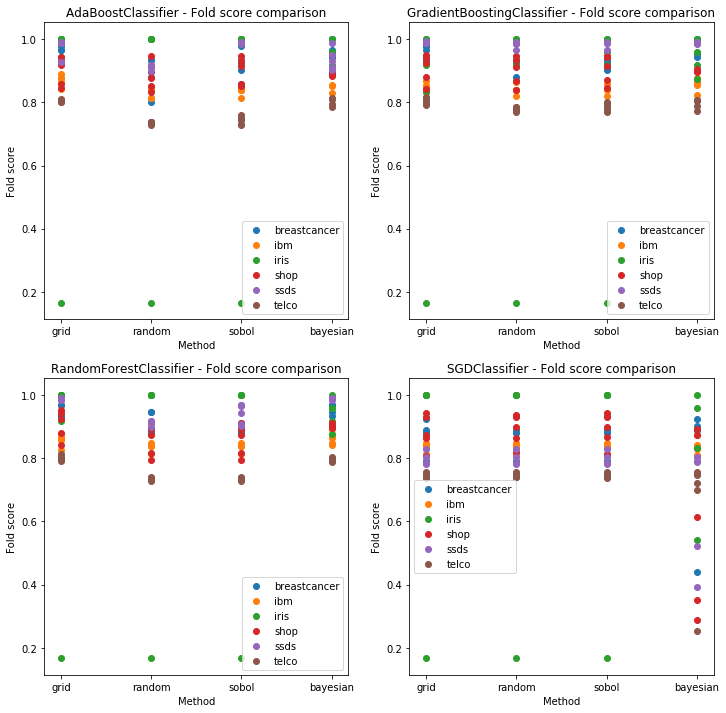

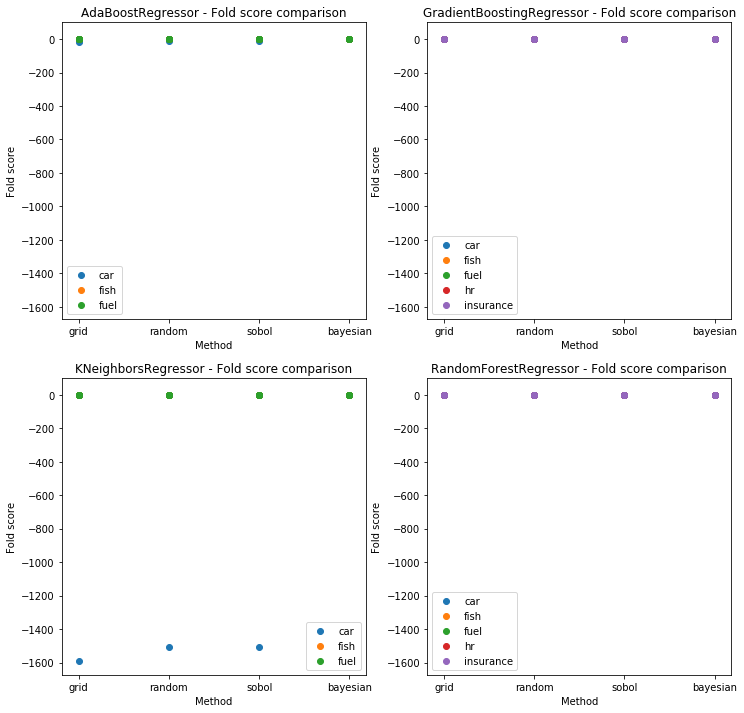

In [5]:
plot_res["Fold score";`res]prep_for_plot'[`fold_score;class_mdlres]
plot_res["Fold score";`res]prep_for_plot'[`fold_score;reg_mdlres]

### Testing score results

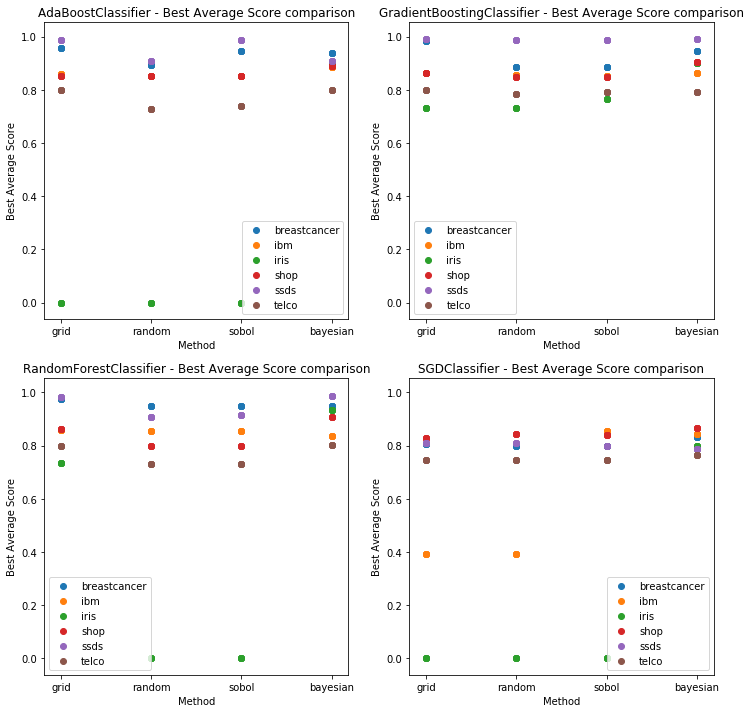

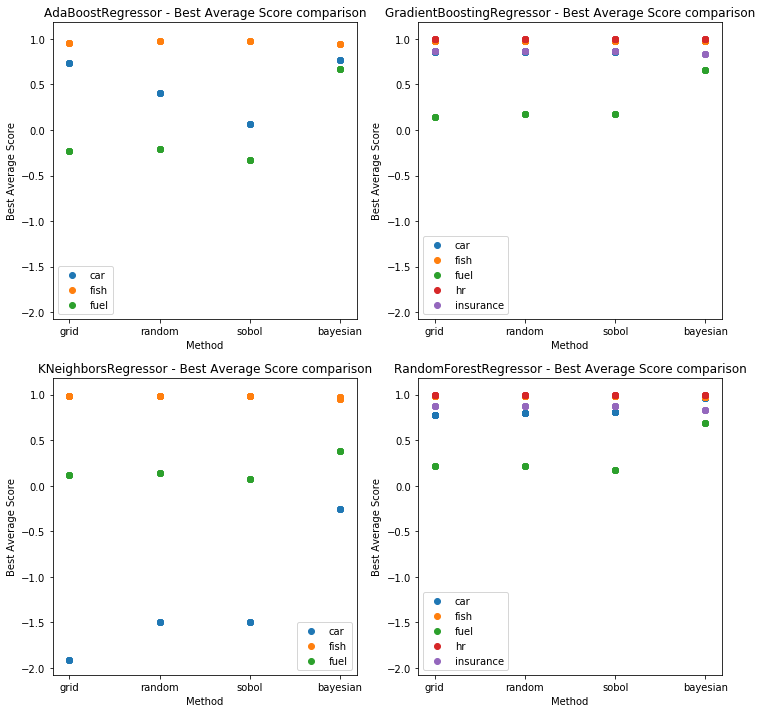

In [6]:
plot_res["Best Average Score";`res]prep_for_plot'[`score;class_mdlres]
plot_res["Best Average Score";`res]prep_for_plot'[`score;reg_mdlres]

### Time comparison

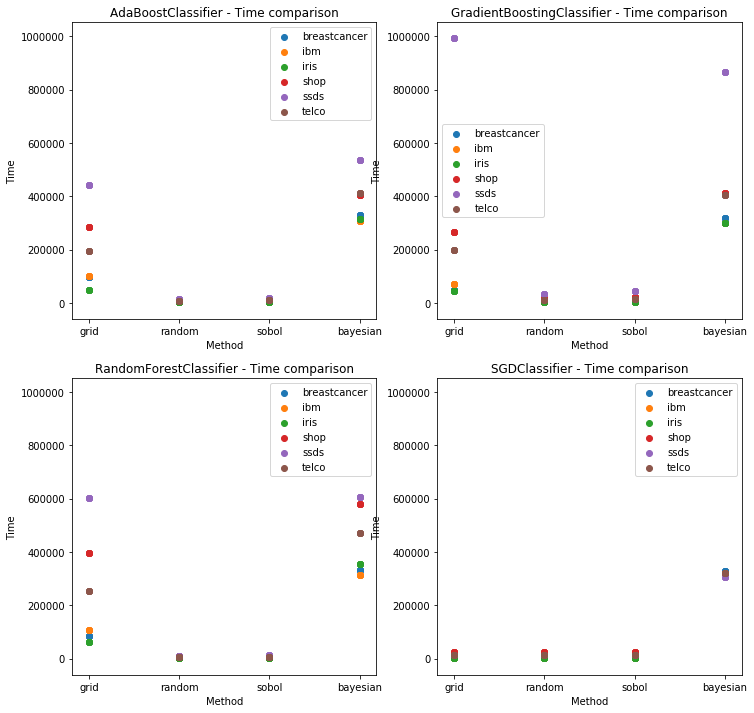

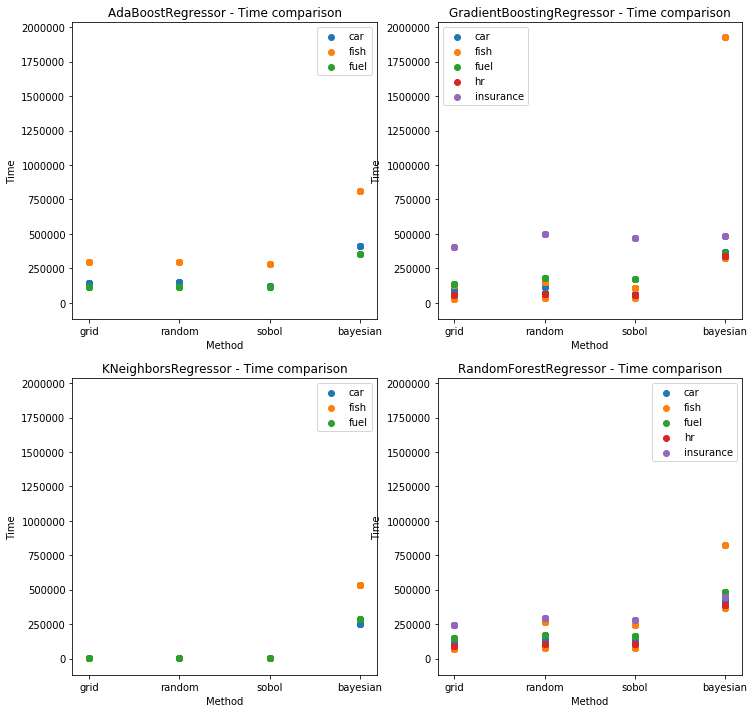

In [7]:
plot_res["Time";`res]prep_for_plot'[`time;class_mdlres]
plot_res["Time";`res]prep_for_plot'[`time;reg_mdlres]

### Fold score stats

In [8]:
get_stats:{
  x:raze{flip@[x;;{5#x}]cols[x]except`fold_score}each x;
  (first x`mdl;d;enlist{[x;y](avg;dev)@\:exec fold_score from x where method=y}[x]each d:distinct x`method)}

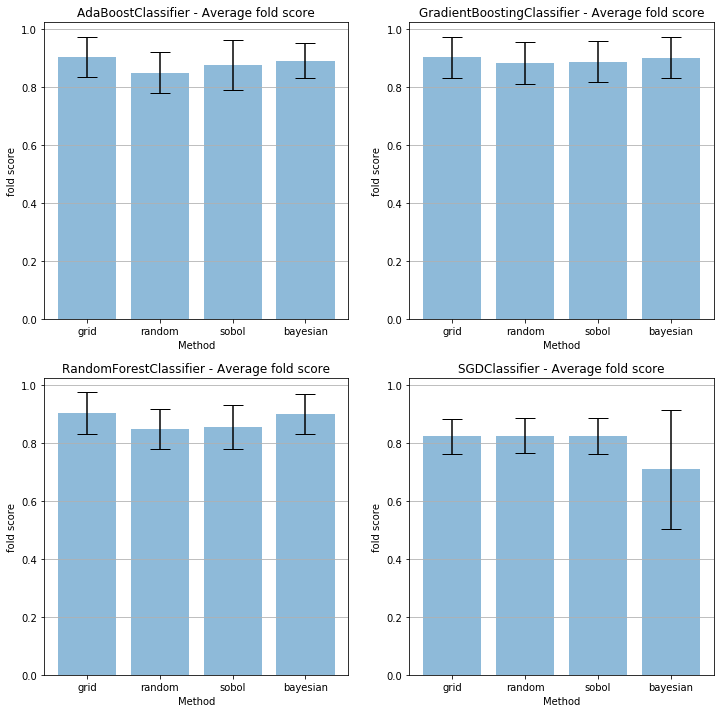

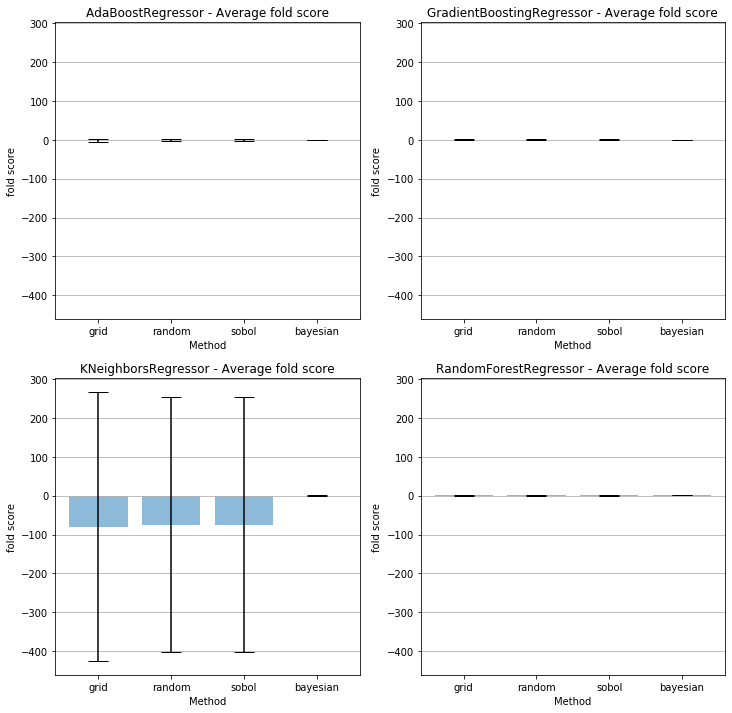

In [9]:
class_mdlres_stats:{[x]select from x where dataset<>`iris}each class_mdlres
reg_mdlres_stats:{[x]select from x where dataset<>`iris}each reg_mdlres
plot_res["fold score";`stats]gs_class:get_stats each class_mdlres_stats
plot_res["fold score";`stats]gs_reg:get_stats each reg_mdlres_stats

## Tabular results

In [10]:
show stats_class:raze{[x]update method:x 1,model:x 0 from flip`mean`stddev!flip raze x 2}each gs_class
show stats_reg:raze{[x]update method:x 1,model:x 0 from flip`mean`stddev!flip raze x 2}each gs_reg

mean      stddev     method   model                     
--------------------------------------------------------
0.9039436 0.06796068 grid     AdaBoostClassifier        
0.8503658 0.06978585 random   AdaBoostClassifier        
0.8770101 0.08676461 sobol    AdaBoostClassifier        
0.8915175 0.05955141 bayesian AdaBoostClassifier        
0.9030636 0.07122589 grid     GradientBoostingClassifier
0.8821038 0.07263367 random   GradientBoostingClassifier
0.8878081 0.07129736 sobol    GradientBoostingClassifier
0.9013523 0.07110372 bayesian GradientBoostingClassifier
0.9031424 0.0714733  grid     RandomForestClassifier    
0.8497038 0.06901476 random   RandomForestClassifier    
0.8548683 0.07516215 sobol    RandomForestClassifier    
0.9008749 0.06921503 bayesian RandomForestClassifier    
0.8234238 0.059862   grid     SGDClassifier             
0.8252063 0.06105122 random   SGDClassifier             
0.8253534 0.06173856 sobol    SGDClassifier             
0.7091465 0.2047914  bayesian S

In [11]:
fnc:{[x;y]?[x;enlist(in;`method;enlist y);0b;`stddev`mean`method!((avg;`stddev);(avg;`mean);(first;`method))]}
raze fnc[stats_class]each distinct stats_class`method
raze fnc[stats_reg]each distinct stats_reg`method

stddev     mean      method  
-----------------------------
0.06763047 0.8833933 grid    
0.06812137 0.8518449 random  
0.07374067 0.86126   sobol   
0.1011654  0.8507228 bayesian


stddev    mean      method  
----------------------------
87.94939  -19.55542 grid    
83.12771  -18.43729 random  
83.00091  -18.41413 sobol   
0.2630095 0.7567537 bayesian


---